In [12]:
import numpy             as np
import matplotlib.pyplot as plt
from matplotlib          import rc 
from matplotlib          import cm
from mpl_toolkits.mplot3d import Axes3D
 

In [2]:
file = 'data/MC.dat'
data = np.loadtxt(file, comments='#')
X = data[:,0]
YObs = data[:,1]
print(X,YObs)

(array([0., 1., 2., 3., 4., 5.]), array([ 8.     ,  6.4    ,  3.14159,  1.5707 ,  0.     , -1.5    ]))


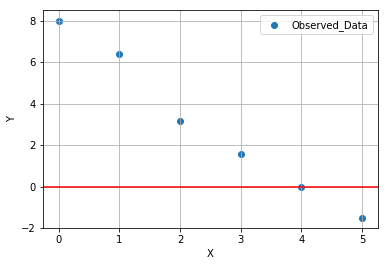

In [3]:
plt.scatter(X, YObs, label="Observed_Data")
plt.grid()
plt.axhline(y=0, c='r')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc=0)

# Modelo de Ajuste

Definimos un modelo matemático para ajustar los datos. La función depende de la variable $x$ y de dos parámetros de ajuste $m$ y $b$.

$$ Y_{fit} = mx + b $$

In [4]:
def Model(x, m, b):
    return m*x + b

m1, b1 = -1, 4
m2, b2 = -2, 7

Xtest = np.linspace(0.,6.,30)
Y1fit = Model(Xtest, m1, b1)
Y2fit = Model(Xtest, m2, b2)

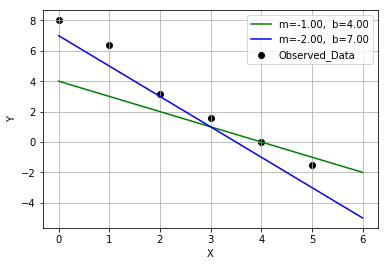

In [5]:
plt.scatter(X, YObs, c='k' ,label="Observed_Data")
plt.plot(Xtest, Y1fit, c='g', label=r"m=%.2f,  b=%.2f" %(m1,b1))
plt.plot(Xtest, Y2fit, c='b', label=r"m=%.2f,  b=%.2f" %(m2,b2))

plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.legend(loc=0)

## Función de Costo

Observación: El modelo $model(m_{2},b_{2})$ describe mejor los datos que el modelo $model(m_{1},b_{1})$. Para cuantificar el nivel de acuerdo entre los datos observados y el modelo usamos una función de costo:

$$  \chi^{2}(m,b) = \sum_{i = 0}^{N} \frac{ \left (Y_{Obs,i} - Y_{fit}\right)^{2} }{2\sigma^{2}}$$
$$  \chi^{2}(m,b) = \sum_{i = 0}^{N} \frac{ \left (Y_{Obs,i} - (m X_{i}+b)\right)^{2} }{2\sigma^{2}}$$

In [6]:
def Chi2(m,b):
    Y_fit = Model(X, m, b)
    chi2 = 0.
    sigma = 1.
    for i in range(len(X)):
        chi2 += (YObs[i]-Y_fit[i])**2/(2.*sigma**2)
    return chi2

In [7]:
# para mi primer y segundo punto del espacio de parámetros:
print(Chi2(-1,4), Chi2(-2,7))

(14.719463109050002, 3.2778731090500006)


In [8]:
Model = np.vectorize(Model)
Chi2 = np.vectorize(Chi2)

m_ = np.arange(-5, 0.,0.25)
b_ = np.arange(0.,10, 0.25)
m_, b_ = np.meshgrid(m_,b_)
z = Chi2(m_,b_)

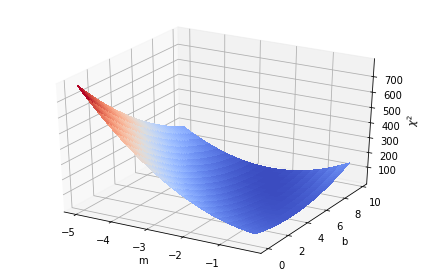

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(m_, b_, z, cmap=cm.coolwarm ,linewidth=0, antialiased=False)
ax.set_xlabel("m")
ax.set_ylabel("b")
ax.set_zlabel(r"$\chi^2$")
plt.tight_layout()

# Metropolis Hastings algorithm

Hacemos una comparasión ($\alpha$) para decidir si damos el paso de $x_{0}$ a $x_{n}$
$$ \alpha = \frac{\pi(x_{n})}{\pi(x_{0})} $$

Generamos $x_{n} = x_{o}\Delta r(-1, 1)$, donde $r$ es un número aleatorio entre -1 y 1. Para nuestro problema de dos parámetros tenemos: $m_{n} = m_{o}\Delta r(-1, 1)$, $b_{n} = b_{o}\Delta r(-1, 1)$ 

$$ \alpha = \frac{\exp(-\chi^2(m_n, b_n))}{\exp(-\chi^2(m_o, b_o))}$$

In [65]:
def Metropolis(m0_, b0_, WidthSteps, NSteps, burned):
    
    mcmc_steps = []
    burn_steps = 3000.
    
    for i in range(NSteps):
        P0 = np.exp( -Chi2(m0_, b0_) )
        
        mn_ = m0_ + WidthSteps*2.*(np.random.rand() - 0.5)
        bn_ = b0_ + WidthSteps*2.*(np.random.rand() - 0.5)
        
        #print(mn_, bn_)
        
        Pn = np.exp( -Chi2(mn_, bn_) )
    
        if( P0 == 0):
            P0 = 0.00001
            
        alpha = Pn/P0        
        
        if(burned):
            beta = np.random.rand()
            if( np.minimum(alpha, 1) >= beta): 
                m0_ = mn_
                b0_ = bn_
    
            if (i >= burn_steps):       # Guardemos los pasos DESPUÉS del calentamiento.
                mcmc_steps.append([m0_, b0_])
        else:
            
            if(alpha >= 1.0): # aceptar de inmediato
                mcmc_steps.append([mn_,bn_])
                m0_ = mn_
                b0_ = bn_
            else:
                beta = np.random.rand()
                if(alpha >= beta): # aceptar el paso
                    mcmc_steps.append([mn_,bn_])
                    m0_ = mn_
                    b0_ = bn_
                else: # no se acepta el paso
                    mcmc_steps.append([m0_,b0_])

    mcmc_steps = np.array(mcmc_steps)
    return mcmc_steps

In [76]:
mcmc = Metropolis(-3, 5, 0.05 ,50000, False)

M=mcmc[:,0]
B=mcmc[:,1]

Text(0,0.5,'$b$')

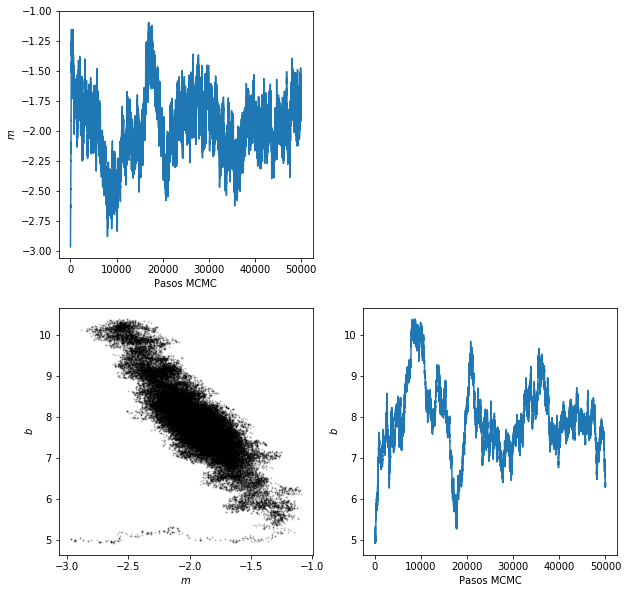

In [77]:
fig = plt.figure( figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(M)
ax1.set_xlabel("Pasos MCMC")
ax1.set_ylabel(r'$m$')

ax3.scatter(M, B, c='k', s=1, alpha=0.2)
ax3.set_xlabel(r'$m$')
ax3.set_ylabel(r'$b$')

ax4.plot(B)
ax4.set_xlabel("Pasos MCMC")
ax4.set_ylabel(r'$b$')


Text(0.5,0,'$b$')

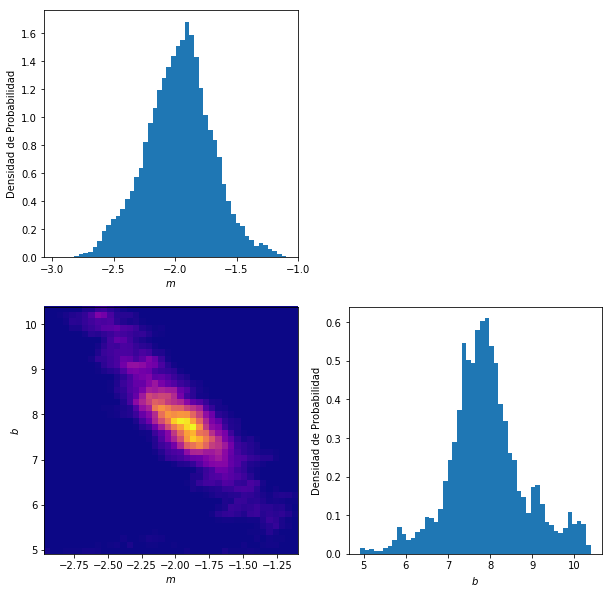

In [78]:
fig = plt.figure( figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.hist(M, 50, density=True)
ax1.set_ylabel('Densidad de Probabilidad')
ax1.set_xlabel(r'$m$')

ax3.hist2d(M, B, bins=40, normed=False, cmap='plasma')
ax3.set_xlabel(r'$m$')
ax3.set_ylabel(r'$b$')

ax4.hist(B, 50, density=True)
ax4.set_ylabel('Densidad de Probabilidad')
ax4.set_xlabel(r'$b$')

In [83]:
for i in range(2):
    mean = np.percentile( mcmc[:,i], 50)
    sigma1 = np.percentile( mcmc[:,i], 16.)
    sigma2 = np.percentile( mcmc[:,i], 84.)
    
    print(mean, sigma2-mean, mean-sigma1)

(-1.9584427952213659, 0.2484113824726102, 0.2740536340337685)
(7.85599760983848, 0.8731220400861952, 0.6759792810844569)


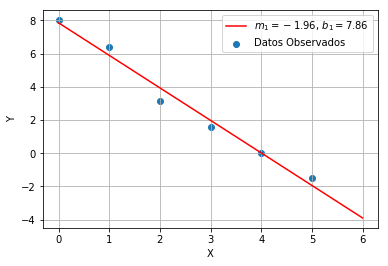

In [84]:
plt.scatter(X, YObs, label="Datos Observados")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()

m_estimated = -1.958
b_estimated = 7.855

Xtest = np.linspace(0.,6.,30)
Yfit = Model(Xtest, m_estimated, b_estimated)
plt.plot(Xtest, Yfit, c='r', label=r"$m_1= {:.2f}$, $b_1={:.2f}$".format(m_estimated, b_estimated))
plt.legend(loc=0)
plt.show()